# MAE Performance (Masked MSE + Per-feature Error + Fake-missing Imputation)

This notebook evaluates MAE reconstruction performance in the **standardized feature space**:

1. **Overall masked MSE** (`train/loss` proxy): average MAE masked reconstruction MSE on `X_lake`.
2. **Per-feature reconstruction error**: mask one feature at a time and compute MSE for that feature.
3. **Fake-missing (imputation) evaluation**: same as (2), plus true-vs-recon scatter plots.

Reusable code lives in `src/models/mae_metrics.py`.


In [1]:
from __future__ import annotations

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch

from src.constants import BRINE_FEATURE_COLUMNS
from src.models.mae import TabularMAE, TabularMAEConfig
from src.models.mae_metrics import (
    feature_true_vs_pred,
    masked_mse_dataset,
    per_feature_drop_mse,
)


def auto_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    if getattr(torch.backends, "mps", None) is not None and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")


PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
MAE_CKPT = PROJECT_ROOT / "models" / "mae_pretrained.pth"

DEVICE = auto_device()
# Metrics can be sensitive to backend kernels on some platforms.
# Use CPU for evaluation by default for stable results.
EVAL_DEVICE = torch.device("cpu")
DEVICE, EVAL_DEVICE

(device(type='mps'), device(type='cpu'))

In [2]:
x_path = PROCESSED_DIR / "X_lake.npy"
assert x_path.exists(), f"Missing: {x_path}. Run build_features first."
assert MAE_CKPT.exists(), f"Missing: {MAE_CKPT}. Train MAE first."

X = np.load(x_path)
print("X:", X.shape, X.dtype)

ckpt = torch.load(MAE_CKPT, map_location="cpu")
cfg = TabularMAEConfig(**ckpt.get("mae_config", {}))
model = TabularMAE(num_features=int(ckpt["num_features"]), config=cfg)
model.load_state_dict(ckpt["model_state_dict"])
model.eval().to(DEVICE)

print("Loaded MAE config:", cfg)
assert X.shape[1] == model.num_features

X: (946, 9) float32
Loaded MAE config: TabularMAEConfig(d_model=256, n_heads=16, n_layers=4, mlp_ratio=2.0, dropout=0.1, mask_ratio=0.1)


/Users/jiahaozhang/miniconda3/envs/global-brine-lithium-model/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


## 1) Overall masked MSE (train/loss proxy)

This is the same masked-MSE objective as training, evaluated on the dataset (standardized space).

In [3]:
mask_ratio = float(getattr(cfg, "mask_ratio", 0.1))
loss = masked_mse_dataset(model, X, mask_ratio=mask_ratio, batch_size=256, seed=42, device=EVAL_DEVICE)
print(f"masked MSE (mask_ratio={mask_ratio}): {loss:.6f}")

masked MSE (mask_ratio=0.1): 0.368607


## 2) Per-feature reconstruction error (drop single feature)

For each feature `j`, we take all rows where that feature is observed, mask only that feature, and compute MSE on that feature.

Na_gL       mse=0.106295  n=939
Mg_gL       mse=0.124112  n=946
Ca_gL       mse=0.127491  n=937
K_gL        mse=0.205377  n=938
Cl_gL       mse=0.258831  n=899
Li_gL       mse=0.287793  n=946
SO4_gL      mse=0.349800  n=889
MLR         mse=0.810953  n=946
TDS_gL      mse=0.980259  n=656


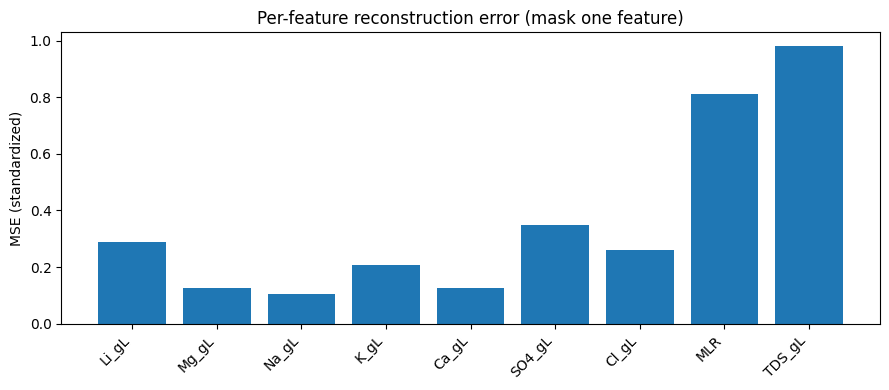

In [4]:
results = per_feature_drop_mse(model, X, batch_size=256, device=EVAL_DEVICE)

mse = np.array([r.mse for r in results], dtype=np.float64)
n = np.array([r.n for r in results], dtype=np.int64)

order = np.argsort(mse)
for idx in order:
    print(f"{BRINE_FEATURE_COLUMNS[idx]:<10}  mse={mse[idx]:.6f}  n={n[idx]}")

plt.figure(figsize=(9, 4))
plt.bar(range(len(BRINE_FEATURE_COLUMNS)), mse)
plt.xticks(range(len(BRINE_FEATURE_COLUMNS)), BRINE_FEATURE_COLUMNS, rotation=45, ha="right")
plt.ylabel("MSE (standardized)")
plt.title("Per-feature reconstruction error (mask one feature)")
plt.tight_layout()
plt.show()

## 3) Fake-missing imputation visualization (true vs recon)

Pick a few features (best/worst) and plot true vs reconstructed values (standardized space).


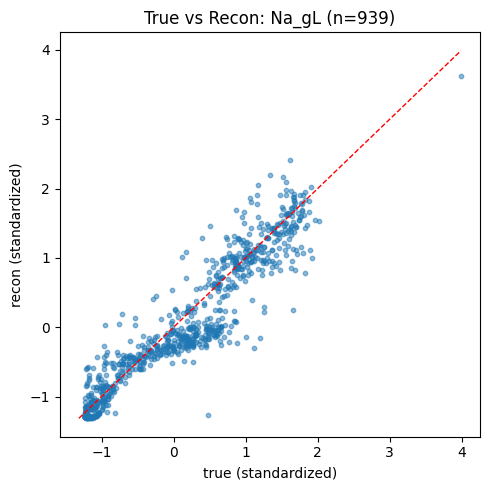

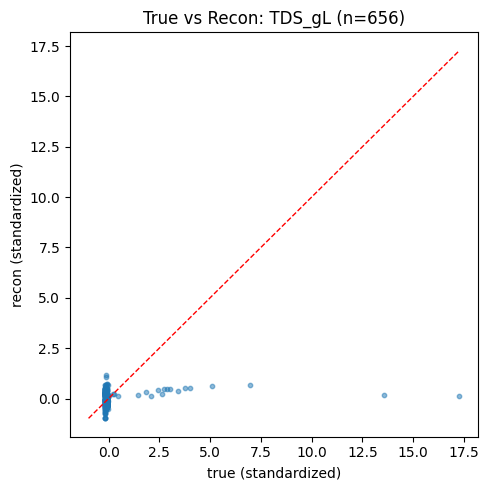

In [5]:
best_idx = int(np.nanargmin(mse))
worst_idx = int(np.nanargmax(mse))
chosen = [best_idx, worst_idx]

for j in chosen:
    y_true, y_pred = feature_true_vs_pred(model, X, feature_index=j, batch_size=256, device=EVAL_DEVICE)
    lim_lo = float(np.nanmin([y_true.min(), y_pred.min()]))
    lim_hi = float(np.nanmax([y_true.max(), y_pred.max()]))

    plt.figure(figsize=(5, 5))
    plt.scatter(y_true, y_pred, s=10, alpha=0.5)
    plt.plot([lim_lo, lim_hi], [lim_lo, lim_hi], "r--", linewidth=1)
    plt.xlabel("true (standardized)")
    plt.ylabel("recon (standardized)")
    plt.title(f"True vs Recon: {BRINE_FEATURE_COLUMNS[j]} (n={len(y_true)})")
    plt.tight_layout()
    plt.show()